In [21]:
import numpy as np
import matplotlib.pyplot as plt
import random
np.random.seed(12)


In [ ]:
def lin2db(x):
    return 10*np.log10(x)

def db2lin(x):
    return 10**(x/10)

A variável $\Delta$ é referente ao espaço entre as antenas.

A variável $M$ é referente ao número de antenas

A variável $d$ se refere a chegada do sinal

O tempo de chegada do sinal em cada antena é definido por:

$\tau_M(\theta_i) = (M-1)\frac{\Delta \sin{\theta_i}}{c}$

As frequencias espaciais são:

$\mu_i = - \frac{2\pi f_c}{c}\Delta \sin(\theta_i) \therefore \mu_i = -\pi \sin(\theta_i)$ se $\Delta = \frac{\lambda}{2}$



A matriz tem formato $M\times d$

In [ ]:
# Definindo os parametros a serem utilizados

c_velocity = 3e8
frequency = 2.4e9 # 2.4 GHz
wavelength = c_velocity / frequency
delta = wavelength / 2 # Espaço entre cada antena

m_antennas = 8 # Número de antenas
d_chegada = 3 # Distância de chegada
theta_i = np.arange(-60, 61, 1) # Ângulos de chegada
theta_i = np.radians(theta_i)
t_snapshot = 100 # Número de snapshots
snr = 0 # dB

O valor da distância entre cada antena é de 0.06 metros


In [ ]:
# Fazendo os cálculos necessários
mu_spatial_frequency = -np.pi*np.sin(theta_i)

A_ula = np.zeros((m_antennas, d_chegada), dtype=complex)
#A_ula_mod = np.zeros((m_antennas, d_chegada))
#A_ula_phase = np.zeros((m_antennas, d_chegada))

for col in range (d_chegada):
    for row in range (m_antennas):
        A_ula[row, col] = np.exp(1j * row * mu_spatial_frequency[col])
        #A_ula_mod[row, col] = np.abs(A_ula[row, col])
        #A_ula_phase[row, col] = np.angle(A_ula[row, col])

print(A_ula)

[[ 1.        +0.j          1.        +0.j          1.        +0.j        ]
 [-0.9127242 +0.40857623j -0.90100218+0.43381455j -0.88820588+0.45944566j]
 [ 0.66613092-0.74583483j  0.62360987-0.78173572j  0.57781937-0.81616467j]
 [-0.30326343+0.95290676j -0.22274553+0.97487662j -0.13823925+0.99039886j]
 [-0.11253919-0.99364729j -0.22222146-0.97499622j -0.33224955-0.94319152j]
 [ 0.5086979 +0.86094509j  0.62318957+0.78207082j  0.72845125+0.68509764j]
 [-0.81606259-0.57796354j -0.90076886-0.43429881j -0.96177982-0.27382399j]]


In [ ]:

rank = np.linalg.matrix_rank(A_ula)
print(f'O rank da matriz A é {rank}')

O rank da matriz A é 3


In [ ]:

sinal = np.zeros((d_chegada, t_snapshot), dtype=complex)

# Definindo o sinal que é transmitido e deixando-o no formato d x t
for col in range(t_snapshot):
    for row in range(d_chegada):
        sinal[row, col] = np.sin(2*np.pi*frequency)

sinal_aula = np.dot(A_ula, sinal)
# Adicionando ruído ao sinal, fazendo do ruído um ruído branco gaussiano com desvio padrão 1
noise = np.random.normal(0, 1, (m_antennas, t_snapshot)) + 1j*np.random.normal(0, 1, (m_antennas, t_snapshot))
sinal_final = sinal_aula + noise

# Calculando a matriz de covariância
sinal_final_hermetiano = np.conj(sinal_final.T)
covariance_matrix_estimada = np.dot(sinal_final, sinal_final_hermetiano) / t_snapshot


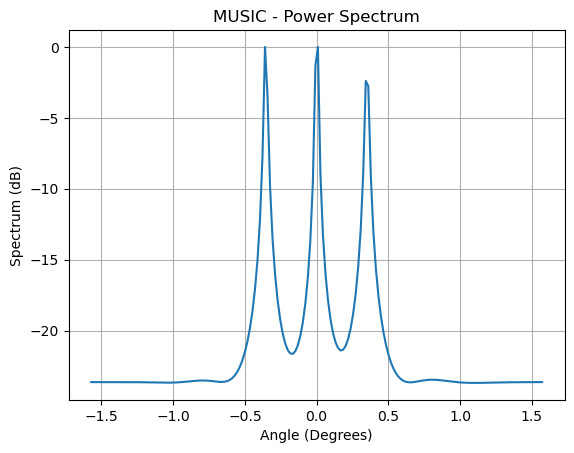

In [ ]:
# Geração do sinal e adição de ruído
sinal = np.random.randn(d_chegada, t_snapshot) + 1j * np.random.randn(d_chegada, t_snapshot)
x = A_ula @ sinal  # Sinal recebido nas antenas
ruido = (np.random.randn(m_antennas, t_snapshot) + 1j * np.random.randn(m_antennas, t_snapshot)) * np.sqrt(db2lin(-snr) / 2)
x_ruido = x + ruido  # Sinal com ruído

# Estimativa da matriz de covariância
Rxx = (1 / t_snapshot) * x_ruido @ x_ruido.conj().T

# Decomposição em autovalores (EVD) para obter os autovetores do subespaço de ruído
eigenvalues, eigenvectors = np.linalg.eig(Rxx)
idx = eigenvalues.argsort()[::-1]  # Ordena os autovalores em ordem decrescente
eigenvectors = eigenvectors[:, idx]
noise_subspace = eigenvectors[:, d_chegada:]  # Subespaço de ruído

# Estimativa do espectro MUSIC
angles = np.linspace(-np.pi / 2, np.pi / 2, 180)  # Ângulos de busca
spectrum = np.zeros(angles.shape, dtype=float)

for i, angle in enumerate(angles):
    steering_vector = np.exp(1j * np.arange(m_antennas) * (-np.pi * np.sin(angle)))
    spectrum[i] = 1 / np.abs(steering_vector.conj().T @ noise_subspace @ noise_subspace.conj().T @ steering_vector)

# Converter para dB
spectrum_db = lin2db(spectrum / np.max(spectrum))

# Plot do espectro MUSIC
plt.plot(angles, spectrum_db)
plt.title("MUSIC - Power Spectrum")
plt.xlabel("Angle (Degrees)")
plt.ylabel("Spectrum (dB)")
plt.grid()
plt.show()
